In [1]:
%pip install jsonlines
%pip install tiktoken
%pip install jupyter ipywidgets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import re

In [3]:
import json
import re
import jsonlines
import tiktoken
import textwrap
import torch
import random
import requests

from pathlib import Path
from collections import deque
from tqdm.notebook import tqdm


In [4]:
from transformers import LlamaForCausalLM, LlamaTokenizer, GenerationConfig

In [ ]:
base_model = "/home/omer/Workspace/vicuna-13b"

In [ ]:
tokenizer = LlamaTokenizer.from_pretrained(base_model)
model = LlamaForCausalLM.from_pretrained(
    base_model,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map="auto",
)

In [ ]:
model = torch.compile(model)

In [ ]:
temperature=0.1
top_p=0.75
top_k=40
num_beams=4
max_new_tokens=128

generation_config = GenerationConfig(
    temperature=temperature,
    top_p=top_p,
    top_k=top_k,
    num_beams=num_beams,
)

In [4]:
sample_data = './HI-TEXT//HelloInternet-01.txt'

In [5]:
def calc(input: str, encoding: str="cl100k_base") -> int:
    tokens = tiktoken.get_encoding(encoding).encode(input)
    return len(tokens)

In [6]:
def load(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    not_empty = []
    for line in lines:
        clean = line.strip()
        if len(clean) == 0:
            continue
        not_empty.append(clean)
        
    return not_empty

In [7]:
def summarize(text, max_len=200):
    prompt = textwrap.dedent(f"""## Input: {text}
    100 word summary: ## Response:
    """)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to("cuda")

    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=max_len,
        )
        s = generation_output.sequences[0]
        output = tokenizer.decode(s, skip_special_tokens=True)
        output = output.split("## Response:")[1].strip()

    return output

In [8]:
vicuna_prompt_template = """### Human: {text}\n\n100 word summary of the conversation between Grey and Brady\n\n### Assistant:"""
vicuna_prompt_template_tone = """### Human: {text}\n\n the tone of the conversation in the format of \"The tone of the conversation is _.\" \n\n### Assistant:"""

def summarize_server(text, max_len=200):
    prompt = vicuna_prompt_template.format(text=text)

    resp = requests.post("http://localhost:8080/generate", json={
        "inputs": prompt,
        "parameters": {
            "temperature": 0.1,
            "top_p": 0.75,
            "top_k": 40,
            "num_beams": 4,
            "max_new_tokens": max_len
    }})
    output = resp.json()["generated_text"].strip()

    # if ### is in the summary, take only the first part
    # sometimes the model generates these segments and they are unneeded
    if "###" in output:
        output = output.split("###")[0].strip()
    
    # Sometimes the model echoes the input
    if "100 word summary of the conversation between Grey and Brady" in output:
        output = output.split("100 word summary of the conversation between Grey and Brady")[1].strip()
    
    return output

def tone_server(text, max_len=200):
    prompt = vicuna_prompt_template_tone.format(text=text)

    resp = requests.post("http://localhost:8080/generate", json={
        "inputs": prompt,
        "parameters": {
            "temperature": 0.1,
            "top_p": 0.75,
            "top_k": 40,
            "num_beams": 4,
            "max_new_tokens": 50
    }})
    output = resp.json()["generated_text"].strip()
    
    # take only the first sentence
    output = output.split(".")[0] + "."

    return output

In [56]:
passage = """
Grey: Please email me if you want a pizza roll. Oh, no, I'm being unoriginal. 

Brady: Did I ever tell you my owl story? 

Grey: No, you did not. What is your owl story? 

Brady: You know, like barn owls, those ones that look really like they look like they look mean and weird. Yeah, yeah. They're quite beautiful, but they're also quite mean and weird looking. 

Grey: Yeah, no, I know exactly what you mean. 

Brady: I was home one day alone at my old house and I was in the kitchen and I just looked to my left and standing in the dining room at night was one of those barn owls, like just looking at me. 

Grey: In the house? 

Brady: In the house. And to this day, I don't know how it got in. I think it must have come down the chimney, but like it looked properly mean and it didn't look happy to be there. And I was like, oh, what am I going to do? So I kind of like went towards her or did something. I don't remember what I did, but it completely spooked it and just started flying around the house. It flew into my office and it was going crazy. And then it flew at Lulu, my dog, who is like the least brave dog in the history of dogs. 

Grey: She's a very, she's a very sweet dog, but she is not a guard dog. 

Brady: She was terrified. So anyway, like I took her away and like locked her in a room and continued my pursuit of this very scared owl and it kind of eventually kind of cornered itself. And like I got this big blanket and I went to throw it on the owl and like, because I was a bit nervous and being a bit wary, I like didn't throw it far enough and it like fell short of the owl. And I think by this point the bird was just like sick of it. And it just like, it basically looked me in the eye and said, look, I think you're going to have to do that again. And I just leaned over and picked it up and threw it a second time and just resigned itself. And like then I picked up the owl inside the blanket and took it outside and threw it in the air and flew away. But I tell you what, gosh, it was exciting. That kind of exciting stuff doesn't happen to urban dwellers like us very often. 

Grey: No, it doesn't. But I would be concerned about that big barn owl because those things have claws that are no joke. 

Brady: Oh, man. Oh, it was scary, you know. 

Grey: Yeah. I think if I came home and there was a barn owl in my house, I might just try to make sure all the windows were open and then just wait. Just think, OK, you will leave eventually. 

Brady: No, you can't put your head in the sand. 

Grey: Why couldn't I? I'm thinking about the current house that I'm in now. There's a door that divides the flat basically into two sections. And so whatever section the owl was in, I would just make sure the windows were open in that section and then close the door and just spend my time in the other section. It's going to leave. There's nothing to eat in the flat. 

Brady: You could go for days without food though, like. 

Grey: But I just- I can't- just for the same reason that I think if a wild animal stumbled across me in the woods, the wild animal could reasonably think, well, this is not a creature who belongs in the forest. I'm sure if we just wait, he'll leave and he'll go back into that indoor environment where he lives. I would look at the owl and think the same thing. 

Brady: Yeah, but the owl wouldn't think that if you were like in its nest, then it would be, hang on a second, I'm going to take action here. This thing's in my nest. 

Grey: Yeah, but it's not- it's just I would wait for the owl is the bottom line. Those talons are big and scary. I mean, we're not talking about like a little screech owl. Those- I mean, if it was a little screech owl, that's different. I would figure, OK, with the blanket, I would be much more concerned about injuring the screech owl. But a barn owl is- I mean, those things are big. 

Brady: I don't- I didn't do it well, but I think it was the right course of action. I think locking it in a room with the window open and hoping for the best was not the- was not what should have been done. All I can say is I really- I really hope Destin doesn't listen to this, our manly country bumpkin friend, because he probably- he probably wrestles owls every morning just for exercise. 
"""

In [57]:
textwrap.wrap(tone_server(passage, max_len=40), 120)

['The tone of the conversation is light-hearted and humorous.']

In [58]:
textwrap.wrap(summarize_server(passage), 120)

['Grey and Brady discuss their experiences with birds in their homes. Grey recounts a time when a bird flew into his house',
 'and he had to chase it out, while Brady tells a story about a barn owl that flew into his house and he had to catch it',
 "and set it free. Grey expresses concern about the potential danger of the barn owl's claws, while Brady defends his",
 "actions and says he hopes Destin, a friend of theirs, doesn't listen to the conversation because he might think it's",
 'acceptable to wrestle owls.']

In [20]:
def process_dialogue(lines, context_len=1500, last_n=6, summarize_fn=summarize_server):
    data = []
    conversation = []
    target_speaker = 'Grey'
    
    for line in tqdm(lines):
        if re.match(r'\w+:', line):
            speaker, utterance = line.split(":", 1)
            utterance = utterance.strip()
            conversation.append(f'{speaker}: {utterance}')
            
            if speaker == target_speaker:
                # Iteratively reduce context until it fits within max_tokens
                context = deque(conversation[:-last_n])
                
                while calc(' '.join(context) + utterance) > context_len:
                    context.popleft()  # Remove sentences from the start until the context fits
                
                context_string = '\n'.join(context)
                current = conversation[-last_n:-1]   # Exclude the last utterance

                # if conversation contains the entierty of the context, don't summarize 
                if len(context) < last_n:
                    #print(f"Skipping summary, conversation len is {context}")
                    summary = ""
                else:
                    summary = summarize_fn(context_string)
                    tone = tone_server(context_string)
                    summary += f"\n\nTone: {tone}"

                conv = "\n".join(current)
                data.append({
                    'input': f'Summary: {summary}\n\n###\n\n{conv}',
                    'output': utterance
                })

    return data

In [21]:
data = load(sample_data)

In [22]:
len(data)

96

In [23]:
processed = process_dialogue(data, context_len=1500)

  0%|          | 0/96 [00:00<?, ?it/s]

In [24]:
def format(q):
    # input is formatted as "Summary: <summary>\n\n###\n\n<conversation>"
    # print summary first
    summary, conversation = q['input'].split("###")
    for line in textwrap.wrap(summary, 120):
        print(line)

    print("---")

    # if "Tone:" in summary:
    #     tone, conversation = rest[0], rest[1]
    #     print(tone.strip())
    #     print("---\n")
    # else:
    #     conversation = "\n".join(rest)
    
    # split the conversation by speakers, and print each speaker's lines wrapped
    for line in conversation.split("\n"):
        if ":" not in line:
            continue

        speaker, utterance = line.split(":", 1)
        for line in textwrap.wrap(f"{speaker}: {utterance}", 120):
            print(line)    
        
        print()

    print("\n--OUTPUT--\n")
    for line in textwrap.wrap(q['output'], 120):
        print(line)

In [27]:
max(calc(q["input"]) for q in processed)

1293

In [48]:
format(processed[8])

Summary: Grey and Brady discuss the pressure of creating videos that are factually correct and avoiding incorrect
information from spreading. Grey admits that a big part of the reason he spends months researching is to avoid being
wrong in public and the fear of receiving hateful comments and criticism. He is also afraid of someone leaving a comment
that demolishes his central arguments in one of his videos. Grey is happy to change his mind in casual conversations but
the process happening in front of a large audience is embarrassing.  Tone: The tone of the conversation is introspective
and contemplative.
---
Brady:  Are you worried about the big howler or the little thing that slipped through the net? Because something that
was said to me by a very wise man and it was very true. That is, when you're making an argument like the ones you're
talking about there, it can be the small thing that undoes you because someone might point out, oh, you said that that
treaty was signed on January 

In [38]:
format(random.choice(processed))

Summary: Grey and Brady discuss the importance of accuracy in news reporting and the pressure to be first to report a
story. Grey believes that there is a case to be made for tolerating the risk of wrongness for the sake of getting
information out quickly. Brady thinks that the BBC's approach of being more reserved in their reporting is admirable,
but also acknowledges that people's short attention spans and the way people's memories work make it difficult for news
organizations to maintain accuracy. Grey agrees that the pressure to be first can lead to mistakes, but also thinks that
it's important to resist that pressure and take the time to research and verify information.  Tone: The tone of the
conversation is light-hearted and casual.
---
Brady:  But yeah, but I would like to hear about, yeah, where's the, where is the cutoff point? That is a, that's a
really interesting thing to hear your opinion on.

Grey:  I would drive any news organization just straight into the ground, right?

In [30]:
full_data = Path("./HI-TEXT/")

In [17]:
processed_data = Path("./HI-TEXT-PROCESSED/")

In [59]:
processed_data.mkdir(exist_ok=True)

In [61]:
def process(filename):
    print(f'Processing {filename}')
    target = processed_data / filename.with_suffix(".jsonl").name
    if target.exists():
        print(f"Skipping {filename}, already processed")
        return
    with jsonlines.open(target, mode='w') as writer:
        data = load(filename)
        for line in tqdm(process_dialogue(data), position=1):
            writer.write(line)

In [2]:
import json

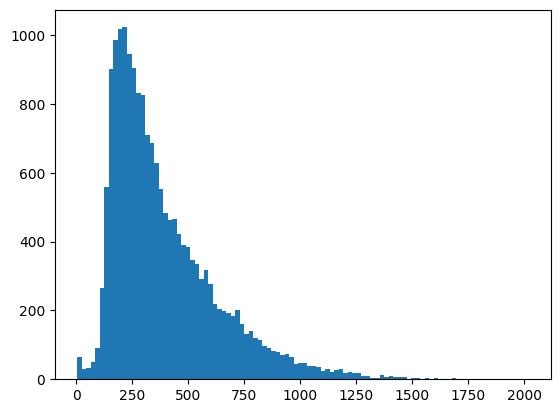

In [124]:
import json
from pathlib import Path

from matplotlib import pyplot as plt

# The list of file names
root = Path("./HI-TEXT-PROCESSED/")


with open("hi_1_100_short.jsonl", "r") as outfile:
    # print histogram of token lengths
    lengths = [calc() for x in outfile]
    plt.hist(lengths, bins=100)
    plt.show()

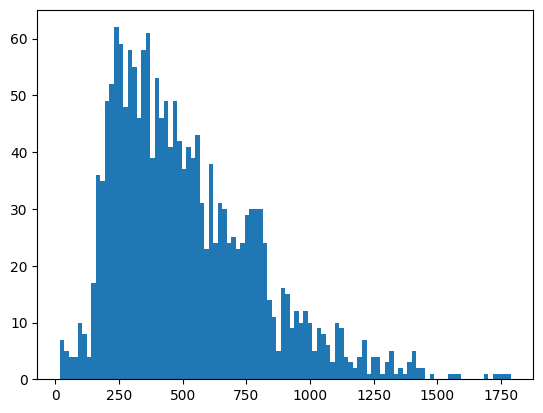

In [16]:
import json
from pathlib import Path

from matplotlib import pyplot as plt
from utils.prompter import Prompter
# The list of file names
root = Path("./HI-TEXT-PROCESSED/")

hi_prompter = Prompter("hi")

with open("hi_1_100_10_percent_short_cleaned.jsonl", "r") as outfile:
    # print histogram of token lengths
    lengths = []
    for line in outfile:
        line = json.loads(line)
    
        line_len = calc(hi_prompter.generate_prompt(line["input"], line["output"]))
        lengths.append(line_len)

    plt.hist(lengths, bins=100)
    plt.show()

{'instruction': 'Give three tips for staying healthy.', 'input': '', 'output': '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.'}


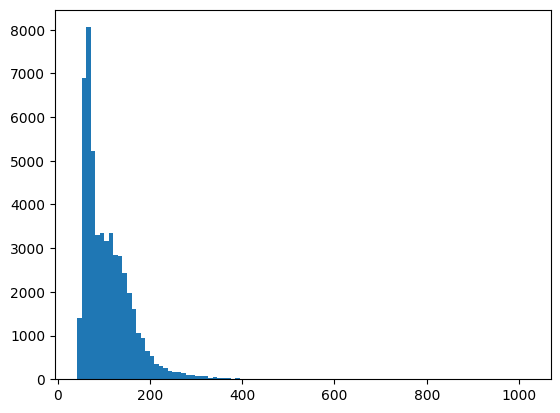

In [10]:
import json
from pathlib import Path

from matplotlib import pyplot as plt
from utils.prompter import AlpacaPrompter

prompter = AlpacaPrompter("alpaca")

alpaca_data = json.load(open("./alpaca_data.json", "r"))
# {
#     "instruction": "Give three tips for staying healthy.",
#     "input": "",
#     "output": "1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule."
# },
print(alpaca_data[0])
lengths = [calc(prompter.generate_prompt(instruction=x['instruction'], input=x['input'], label=x['output'])) for x in alpaca_data]
plt.hist(lengths, bins=100)
plt.show()

In [10]:
import os
import sys
from typing import List

import fire
import torch
import transformers
from datasets import load_dataset

"""
Unused imports:
import torch.nn as nn
import bitsandbytes as bnb
"""

from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
    set_peft_model_state_dict,
)
from transformers import LlamaForCausalLM, LlamaTokenizer

from utils.prompter import Prompter



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/omer/Workspace/alpaca-lora/.venv/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/home/omer/Workspace/alpaca-lora/.venv/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('vs/workbench/api/node/extensionHostProcess')}
  warn(msg)
/home/omer/Workspace/alpaca-lora/.venv/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//matplotlib_inline.backend_inline'), PosixPath('module')}
  warn(msg)


In [11]:
data = load_dataset("json", data_files="./hi_1_100_short_cleaned.jsonl")

Found cached dataset json (/home/omer/.cache/huggingface/datasets/json/default-6cf8c95b540cdefd/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
dd = data['train'][20]

In [23]:
prompter = Prompter("hi")

In [24]:
prompter.generate_prompt(dd['input'], dd['output'])

"Summary: Grey and Brady discuss mistakes in their work and how they handle them. Grey mentions that he has a section in his newspaper where they correct mistakes from the previous day's paper, and he enjoys reading it.\n\nTone:  The tone of the conversation is self-deprecating and humorous.\n\n###\n\nBrady: Let me tell you this, Rob. I know this is about being wrong on the Internet. And being wrong on the Internet is a bad thing. But as someone who used to work in newspapers, I can promise you being wrong in newspapers is worse because it's printed so many times and it's a hard copy and you see it everywhere. and then you go out for a coffee break and you see piles and piles of the newspaper sitting in the shop with your mistakes sitting on the front page. That has happened to me. One of my first ever front page stories was about a big march or parade that was happening in my hometown. And I swaggered into work the next day, Mr. Front Page, thinking I was all that. And then the boss c

In [119]:
def shorten(summary) -> str:
    summary = summary.split("Summary:")[1]
    try:
        summary, tone = summary.split("Tone:")
    except ValueError:
        tone = ""
    
    summary = summary.strip()
    summary_sentences = summary.split(".")
    context = deque(summary_sentences)
        
    while calc(' '.join(context)) > 50:
        context.pop()  # Remove sentences from the end
    
    new_summary = '.'.join(context)
    if new_summary != "":
        new_summary += "."

    if tone != "":
        return f"Summary: {new_summary}\n\nTone: {tone}"
    else:
        return f"Summary: {new_summary}"

In [121]:
# Load all the dataset, and create a version where for each entry, the summary is limited to either 3 sentences or a max of 150 tokens 
dataset  = "./hi_1_100.jsonl"

f = open(dataset, "r")
lines = f.readlines()[:10]
with open(dataset, "r") as f:
    with open("hi_1_100_short.jsonl", "w") as outfile:
        for line in f:
            data = json.loads(line)
            data_input = data['input']
            try:
                summary, text = data_input.split("###")
            except ValueError:
                print(data_input)
                raise
            summary = shorten(summary)
            data['input'] = f"{summary}###{text}"
            ser = json.dumps(data)
            outfile.write(ser + "\n")


In [3]:
# Load all the dataset, and create a version where for each entry, the summary is limited to either 3 sentences or a max of 150 tokens 
dataset  = "./hi_1_100_short.jsonl"

with open(dataset, "r") as f:
    with open("hi_1_100_short_cleaned.jsonl", "w") as outfile:
        for i, line in enumerate(f):
            data = json.loads(line)
            data_input = data['input']
            data_output = data['output']
            if data_output == "":
                print(f"Discarding empty output line {i}")
                continue
            new = {
                'input': data_input,
                'output': f" {data_output}\n"
            }
            ser = json.dumps(new)
            outfile.write(ser + "\n")
            

Discarding empty output line 3821
Discarding empty output line 15502


In [112]:
j = json.loads(line)

In [1]:
import json
from collections import deque
import tiktoken

In [4]:
from transformers import LlamaTokenizer

In [11]:
tokenizer = LlamaTokenizer.from_pretrained("huggyllama/llama-7b")
def calc_llama(input: str) -> int:
    tokens = tokenizer.tokenize(input)
    return len(tokens)

In [12]:
from utils.prompter import Prompter
# Load all the dataset and keep only entries whose prompt is less then 512 tokens
dataset  = "./hi_1_100_short_cleaned.jsonl"

hi_prompt = Prompter("hi")

with open(dataset, "r") as f:
    with open("hi_1_100_lt_512_short_cleaned.jsonl", "w") as outfile:
        for i, line in enumerate(f):
            data = json.loads(line)
            data_input = data['input']
            data_output = data['output']
            if data_output == "":
                print(f"Discarding empty output line {i}")
                continue
            prompt_len = calc_llama(hi_prompt.generate_prompt(data_input, data_output))
            print(prompt_len)
            if prompt_len > 512:
                print(f"Discarding line {i} because prompt is too long")
                continue
                
            
            new = {
                'input': data_input,
                'output': f" {data_output}\n"
            }
            ser = json.dumps(new)
            outfile.write(ser + "\n")
            

41
100
237
452
486
727
Discarding line 5 because prompt is too long
1113
Discarding line 6 because prompt is too long
1364
Discarding line 7 because prompt is too long
1330
Discarding line 8 because prompt is too long
870
Discarding line 9 because prompt is too long
618
Discarding line 10 because prompt is too long
564
Discarding line 11 because prompt is too long
634
Discarding line 12 because prompt is too long
535
Discarding line 13 because prompt is too long
379
226
297
299
764
Discarding line 18 because prompt is too long
779
Discarding line 19 because prompt is too long
780
Discarding line 20 because prompt is too long
378
335
315
806
Discarding line 24 because prompt is too long
1238
Discarding line 25 because prompt is too long
1215
Discarding line 26 because prompt is too long
711
Discarding line 27 because prompt is too long
922
Discarding line 28 because prompt is too long
1164
Discarding line 29 because prompt is too long
1142
Discarding line 30 because prompt is too long
5

In [21]:
from utils.prompter import Prompter
# Load all the dataset and keep only entries whose prompt is less then 512 tokens
dataset  = "./hi_1_100_short_cleaned.jsonl"

hi_prompt = Prompter("hi_detailed")

with open(dataset, "r") as f:
    with open("hi_1_100_lt_1024_short_cleaned.jsonl", "w") as outfile:
        for i, line in enumerate(f):
            data = json.loads(line)
            data_input = data['input']
            data_output = data['output']
            if data_output == "":
                print(f"Discarding empty output line {i}")
                continue
            prompt_len = calc_llama(hi_prompt.generate_prompt(data_input, data_output))
            print(prompt_len)
            if prompt_len > 1024:
                print(f"Discarding line {i} because prompt is too long")
                continue
                
            
            new = {
                'input': data_input,
                'output': f" {data_output}\n"
            }
            ser = json.dumps(new)
            outfile.write(ser + "\n")
            

76
135
272
487
521
762
1148
Discarding line 6 because prompt is too long
1399
Discarding line 7 because prompt is too long
1365
Discarding line 8 because prompt is too long
905
653
599
669
570
414
261
332
334
799
814
815
413
370
350
841
1273
Discarding line 25 because prompt is too long
1250
Discarding line 26 because prompt is too long
746
957
1199
Discarding line 29 because prompt is too long
1177
Discarding line 30 because prompt is too long
543
451
447
1241
Discarding line 34 because prompt is too long
1322
Discarding line 35 because prompt is too long
1331
Discarding line 36 because prompt is too long
710
610
813
670
935
741
894
773
786
579
224
108
123
158
148
162
273
256
279
308
498
1216
Discarding line 58 because prompt is too long
1125
Discarding line 59 because prompt is too long
1080
Discarding line 60 because prompt is too long
655
644
551
688
1060
Discarding line 65 because prompt is too long
1068
Discarding line 66 because prompt is too long
876
553
589
474
539
572
487
416

In [13]:
from datasets import load_dataset


In [16]:
data = load_dataset("json", data_files="./hi_short_test.jsonl")

Found cached dataset json (/home/omer/.cache/huggingface/datasets/json/default-11680bcd564fc7b9/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
data

DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 2000
    })
})